# PetFinder.my Pawpularity Score / Predict

## Imports

In [1]:
# Imports
import os
import numpy as np
from IPython.display import display

# Import utility libs
import petfinder_pawpularity_config as config
import petfinder_pawpularity_lib as mllib
tf_strategy = mllib.tf_strategy()

'TensorFlow Version: 2.6.0'

'TensorFlow Strategy: _DefaultDistributionStrategy'

In [2]:
# Enable retina display
%config InlineBackend.figure_format = "retina"

# Load Tensorboard
%load_ext tensorboard

## Settings

In [3]:
# Settings
settings, debug = config.get_settings(
    process="predict",
    fallback_mode="full"
)
mllib.show_dict(settings)

,Setting,Value
0,env,local
1,process,predict
2,mode,cut
3,debug,True
4,model_load_dir,models
5,model_save_dir,models
6,dataset_dir_src,../input/petfinder-pawpularity-score
7,dataset_dir_cut,../input/petfinder-pawpularity-score
8,dataset_dir_copy,dataset-copy
9,dataset_batch_size,64


## Prepare data

'../input/petfinder-pawpularity-score-cut-0.200'

'Load training data from ../input/petfinder-pawpularity-score-cut-0.200/train.csv'

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,32f4f6afaae9f0633ffd11d3e8589689,0,1,1,1,0,1,0,0,0,0,0,0,45
1978,32f7f313e386e95dad34ffed898fe43c,0,1,1,1,0,0,0,1,1,1,0,0,57
1979,32fa718066e9373a5af30dbb77bf32ee,0,0,0,1,0,0,0,0,0,1,1,0,59
1980,32fb50499ca324b5b49ac5b00a63a923,0,1,1,1,0,1,0,0,0,1,1,0,18


Train / Validate / Test datasets items: 1344 / 384 / 192

Train dataset:
Cause: could not parse the source code of <function <lambda> at 0x7fd9d1926820>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd9d1926820>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


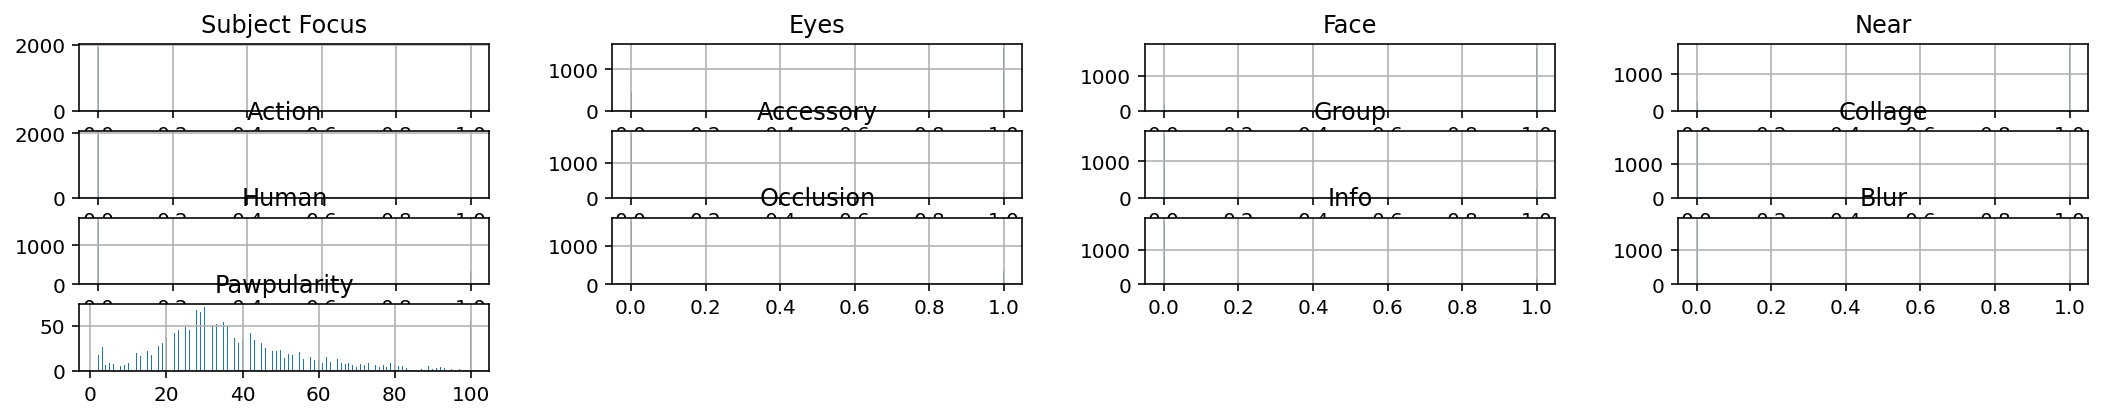

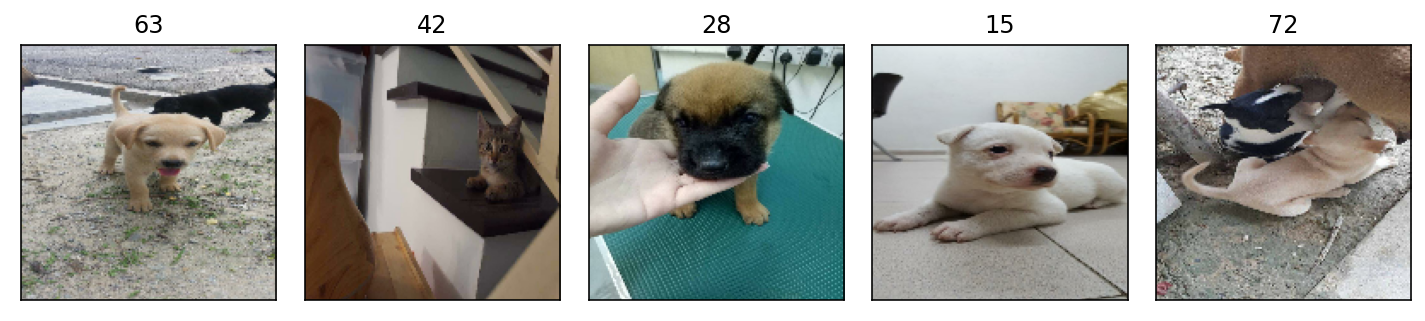

Validate dataset:


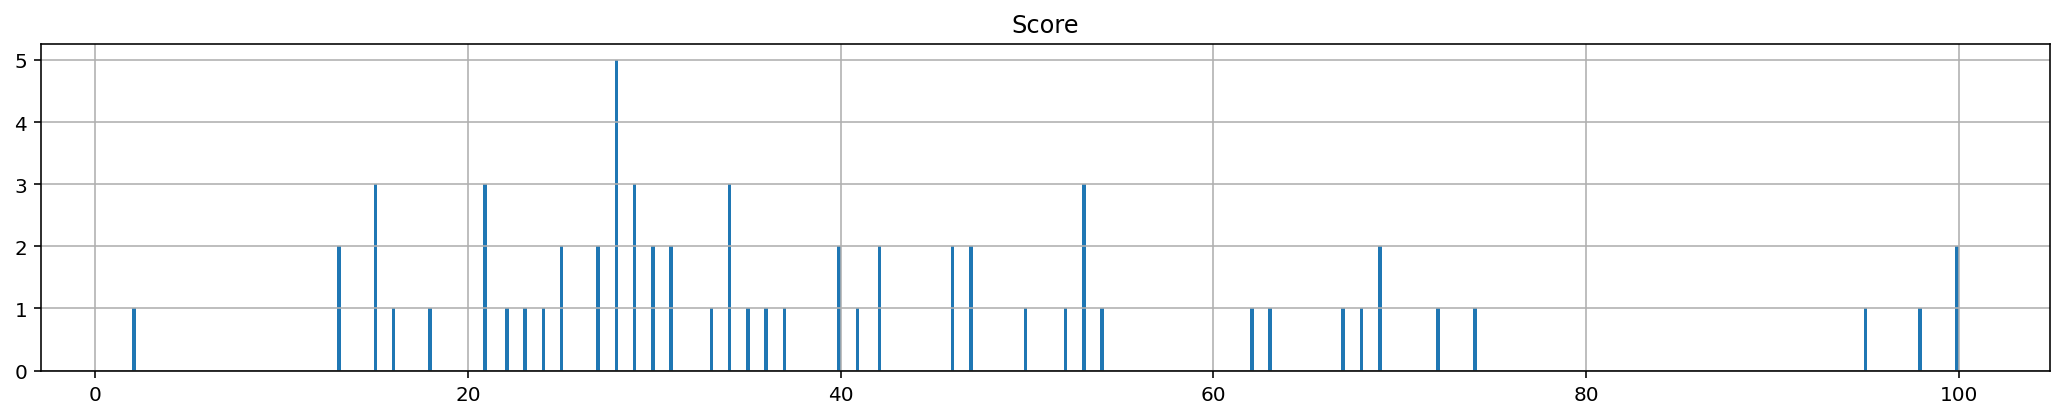

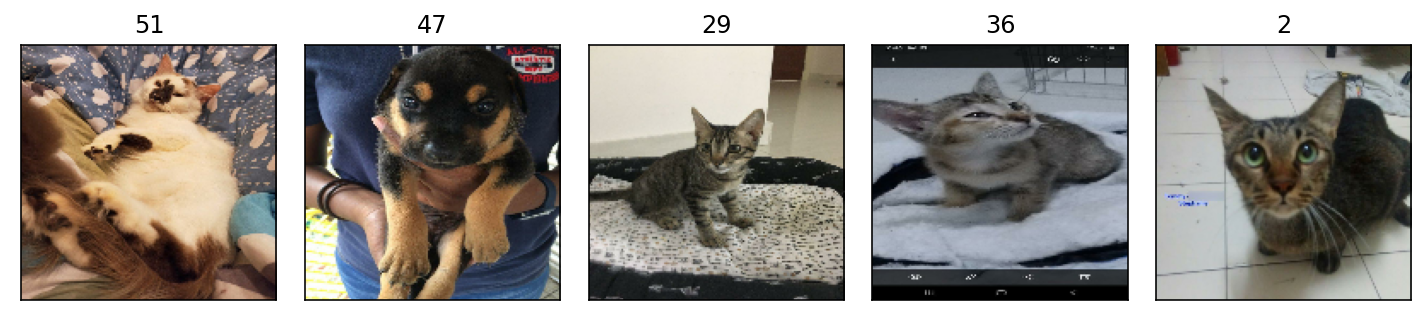

Test dataset:


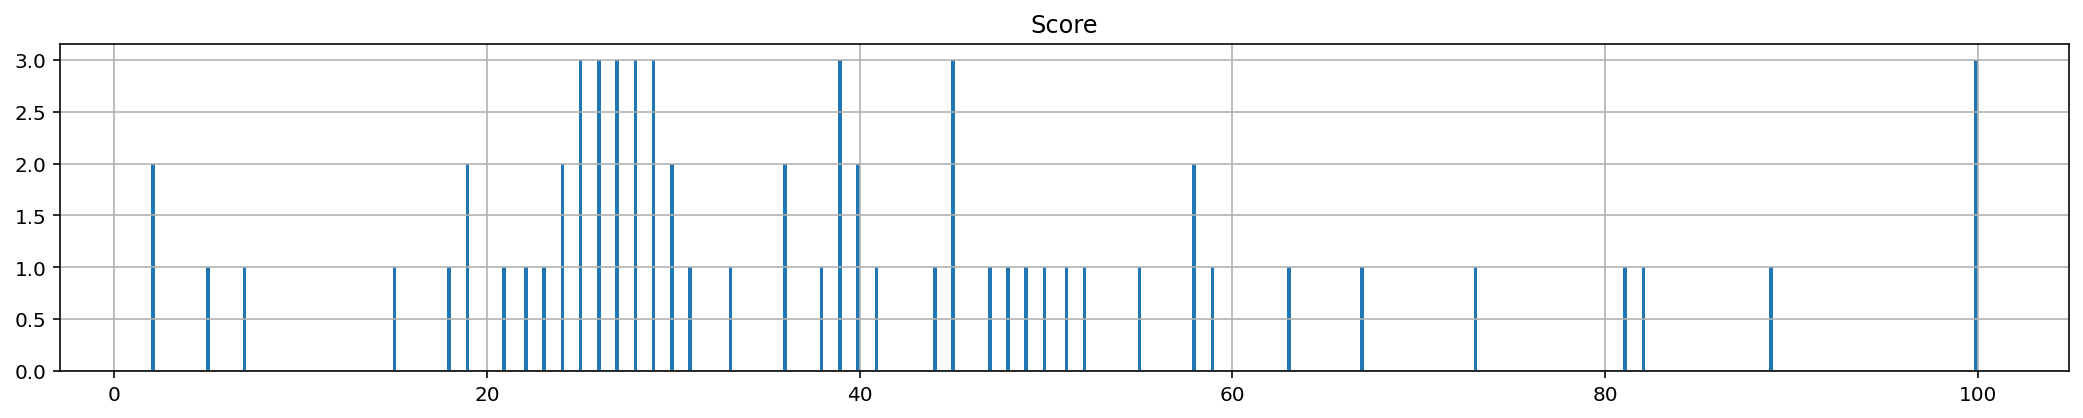

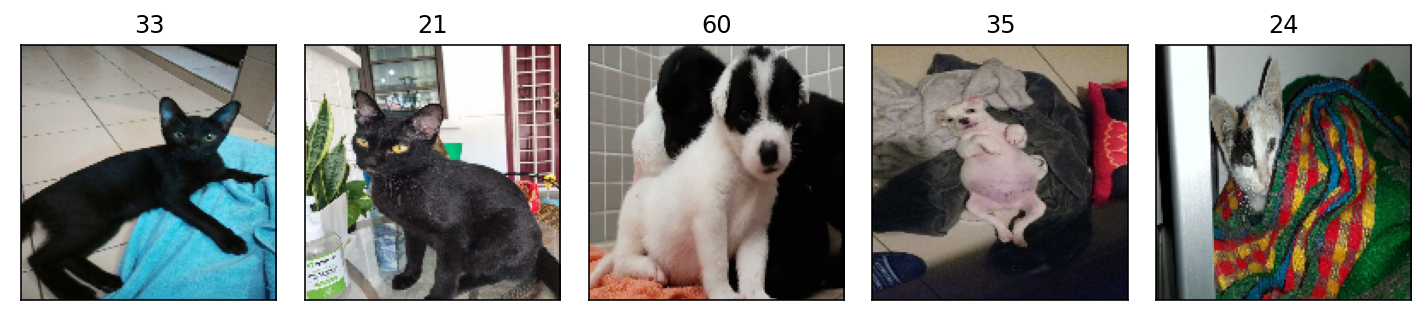

CPU times: user 22.8 s, sys: 1.72 s, total: 24.5 s
Wall time: 20.6 s


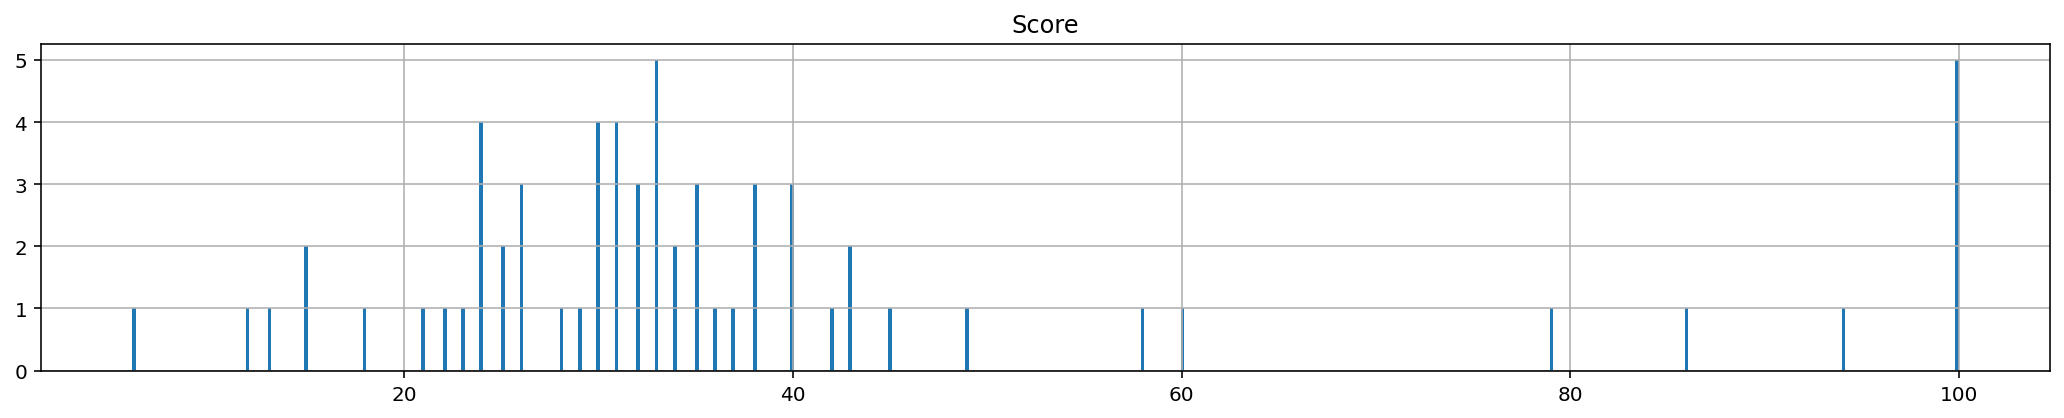

In [4]:
%%time
# Cut training data
dataset_dir = mllib.cut_training_data(
    cut_ratio=settings["dataset_cut_ratio"], 
    dataset_dir_src=settings["dataset_dir_src"], 
    dataset_dir_cut=settings["dataset_dir_cut"]
)
display(dataset_dir)

# Train data
training_data = mllib.load_training_data(dataset_dir)
if debug: 
    display(training_data)
    training_data.hist(bins=500, figsize=(18,3))

# Make training data
map_image_score_fn = lambda image, features, score, file_id: (image, score)  
train_dataset, validate_dataset, test_dataset = mllib.make_training_validate_test_data(
    dataset=mllib.load_training_dataset(
        dataset_dir=dataset_dir,
        mapping_data=training_data,
        batch_size=settings["dataset_batch_size"],
        shuffle=settings["dataset_shuffle"],
        seed=settings["dataset_shuffle_seed"],
        image_size=settings["dataset_image_size"],
    ),
    split_ratios=settings["dataset_split_ratios"],
    shrink_ratio=settings["dataset_shrink_ratio"],
    prefetch=settings["dataset_prefetch"],
)

# Training data infos
print("Train / Validate / Test datasets items: %s / %s / %s" % (
    settings["dataset_batch_size"] * train_dataset().cardinality().numpy(), 
    settings["dataset_batch_size"] * validate_dataset().cardinality().numpy(), 
    settings["dataset_batch_size"] * test_dataset().cardinality().numpy()
))
if debug:
    print("")
    print("Train dataset:")
    mllib.plot_images_scores_from_dataset(train_dataset().take(1).map(map_image_score_fn))
    print("Validate dataset:")
    mllib.plot_images_scores_from_dataset(validate_dataset().take(1).map(map_image_score_fn))
    print("Test dataset:")
    mllib.plot_images_scores_from_dataset(test_dataset().take(1).map(map_image_score_fn))

## Predict

In [5]:
# Prepare model parameters
def get_model_parameters(settings):
    dataset_image_size = settings["dataset_image_size"]
    model_parameters = {
        "model_prefix": "model" + mllib.cut_suffix(settings["dataset_cut_ratio"]),
        "model_base": "xception",
        "input_shape": [dataset_image_size[0], dataset_image_size[1], 3],
        "input_shape_features": len(mllib.feature_fields),
        "output_size": 1,
        "dropout_rate": 0.3,
        "learning_rate": 5e-4,
        "dense_layers": "100",
        "dense_layers_activation": "elu",
        "preload_weights": None,
    }
    model_name = mllib.get_model_name(model_parameters)
    model_parameters["model_name"] = model_name
    return model_parameters
    
model_parameters = get_model_parameters(settings)
display(model_parameters)

{'model_prefix': 'model-cut-0.200',
 'model_base': 'xception',
 'input_shape': [150, 150, 3],
 'input_shape_features': 12,
 'output_size': 1,
 'dropout_rate': 0.3,
 'learning_rate': 0.0005,
 'dense_layers': '100',
 'dense_layers_activation': 'elu',
 'preload_weights': None,
 'model_name': 'model-cut-0.200-xception-input-150x150x3-dense-100-dropout-0.300'}

In [6]:
%%time
# Load model
with tf_strategy.scope():
    model = mllib.setup_model(model_parameters)
    model_file = mllib.load_model(model, settings["model_load_dir"])
    print("Loaded Weights: %s" % model_file)

Model: "model-cut-0.200-xception-input-150x150x3-dense-100-dropout-0.300"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 150, 150, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
tf.math.subtract (TFOpLambda)   (None, 150, 150, 3)  0           tf.math.truediv[0][0]            
__________________________________________________________________________________________________
xception (Functional)           (None, 5, 5, 2048)   20861480    tf.math.subtract[0][0]           
___________________________________

*** Test Image # 1
>>> SUCCESS
>>> Predicted score: 45 vs 44


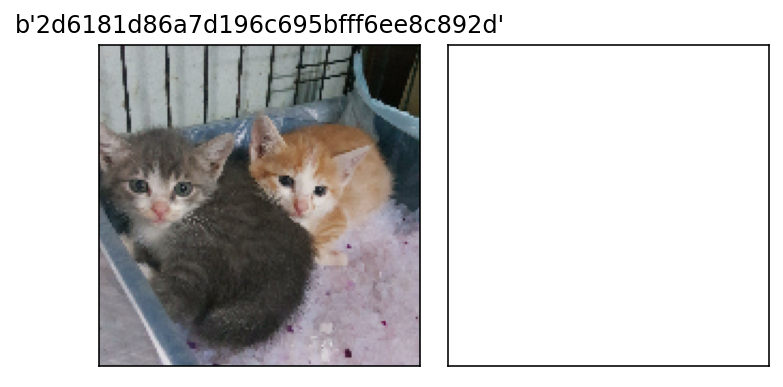


*** Test Image # 2
>>> FAILURE
>>> Predicted score: 44 vs 22


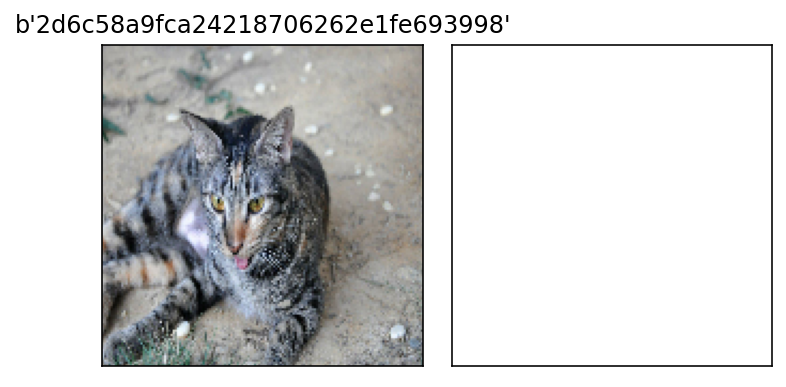


*** Test Image # 3
>>> FAILURE
>>> Predicted score: 41 vs 16


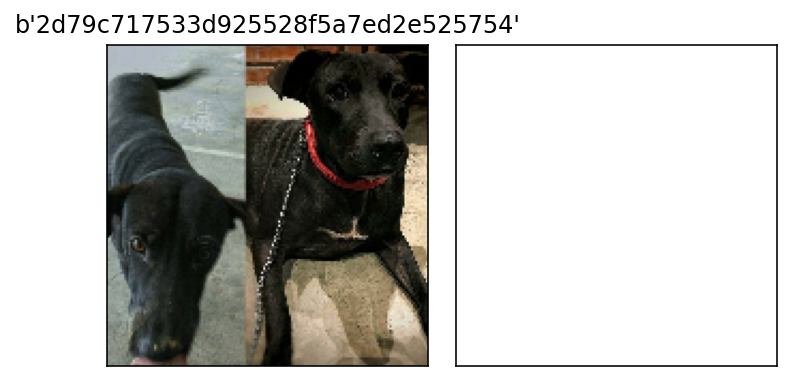


*** Test Image # 4
>>> FAILURE
>>> Predicted score: 44 vs 20


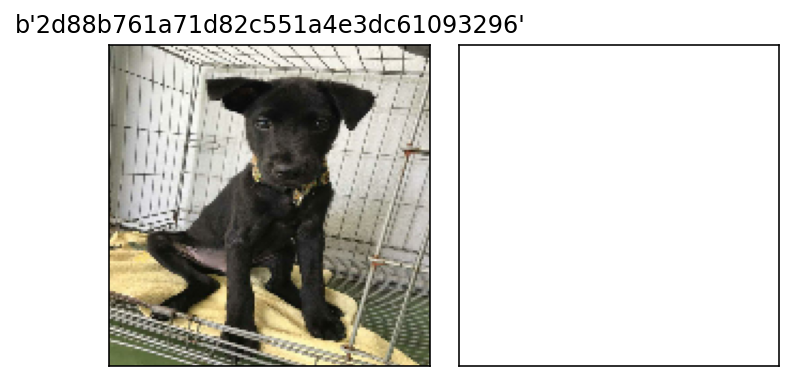


*** Test Image # 5
>>> FAILURE
>>> Predicted score: 55 vs 24


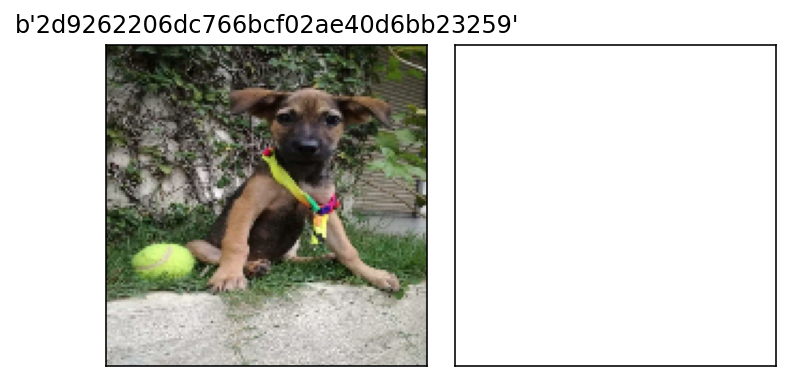


CPU times: user 8.66 s, sys: 1.08 s, total: 9.73 s
Wall time: 6.03 s


In [7]:
%%time
# Predict on test dataset
if debug:
    with tf_strategy.scope():
        images, features, scores, file_ids, *_ = mllib.load_images_scores_from_dataset(test_dataset().shuffle(100).take(1))
        for index in range(len(images[:5])):
            print("*** Test Image #",index+1)
            mllib.predict(
                model=model, 
                image=images[index],
                features=features[index],
                label=file_ids[index],
                true_score=scores[index], 
            )
            print("")

## Score

### Train

In [8]:
%%time
# Score train submission data
train_score, train_scored_data = mllib.score_submission_data(
    submission_data=mllib.infer_submission_data(
        dataset=train_dataset,
        model=model, 
        take=settings["score_sample_size"]
    ), 
    training_data=training_data
)
display("Train Submission RMSE Score [Samples=%i]: %f" % (settings["score_sample_size"], train_score))
if debug: display(train_scored_data)

'Train Submission RMSE Score [Samples=10]: 22.276346'

,index,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,predicted_Pawpularity
0,0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63.0,45.79
1,1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42.0,46.82
2,2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28.0,48.49
3,3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15.0,44.90
4,4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72.0,49.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,635,107ae50725a7d1b403105eb2ab6d5f60,0,0,0,0,0,0,0,0,0,0,0,0,30.0,50.00
636,636,10802a83bd5dc77ec9548c9e8d0c8abf,0,0,1,1,0,0,0,0,0,0,0,1,49.0,42.05
637,637,108519f539e734434cd6819c46f297ff,0,1,1,1,0,0,0,0,0,0,0,0,84.0,44.90
638,638,108b665bd65d664d838de0fa435105e4,0,1,1,1,0,0,0,0,0,0,0,0,33.0,44.90


CPU times: user 1min 40s, sys: 17.2 s, total: 1min 58s
Wall time: 29.4 s


### Validate

In [9]:
%%time
# Score validate submission data
validate_score, validate_scored_data = mllib.score_submission_data(
    submission_data=mllib.infer_submission_data(
        dataset=validate_dataset,
        model=model, 
        take=settings["score_sample_size"]
    ), 
    training_data=training_data
)
display("Validate Submission RMSE Score [Samples=%i]: %f" % (settings["score_sample_size"], validate_score))
if debug: display(validate_scored_data)

'Validate Submission RMSE Score [Samples=10]: 22.582940'

,index,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,predicted_Pawpularity
0,0,225c58c83c8c98c5ba18f6952972eca1,0,0,1,1,0,0,0,0,0,0,0,0,51.0,46.74
1,1,2269fb644034eeda0439026cbfc55f24,0,1,1,1,0,0,0,0,1,1,0,0,47.0,48.49
2,2,226beba069c4288dc67ac1bcc4564896,0,1,1,1,0,0,0,0,0,0,0,0,29.0,44.90
3,3,2270ec839312719f8c924284a291d27e,0,1,1,1,0,0,0,0,0,0,0,0,36.0,44.90
4,4,227432c89950ecd367b809a1593a4fdc,0,0,1,1,0,0,0,0,0,0,1,1,2.0,43.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,379,2bc671f1628743197a9ef3304e87978f,0,1,1,1,0,0,0,0,1,1,0,0,38.0,48.49
380,380,2bd64a0de916b87dbddc28785ed11d88,0,1,1,1,0,0,1,0,0,0,0,0,22.0,45.79
381,381,2be411ab4cb1b8a097c1dc4b254f1bff,0,1,1,1,0,0,0,0,0,0,0,0,25.0,44.90
382,382,2be4d326a6577f163f383625104775c4,0,0,0,1,0,0,0,0,0,0,0,0,24.0,48.11


CPU times: user 58.1 s, sys: 9.94 s, total: 1min 8s
Wall time: 16.1 s


### Test

In [10]:
%%time
# Score test submission data
test_score, test_scored_data = mllib.score_submission_data(
    submission_data=mllib.infer_submission_data(
        dataset=test_dataset,
        model=model, 
        take=settings["score_sample_size"]
    ), 
    training_data=training_data
)
display("Test Submission RMSE Score [Samples=%i]: %f" % (settings["score_sample_size"], test_score))
if debug: display(test_scored_data)

'Test Submission RMSE Score [Samples=10]: 22.928362'

,index,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,predicted_Pawpularity
0,0,2bf45044c9a70b3724c98a1fab3e790f,0,1,1,1,0,0,0,0,0,0,0,0,33.0,44.90
1,1,2c030cb49033cbbaf4a721fc37c1913d,0,1,1,1,0,0,0,0,0,0,0,0,21.0,44.90
2,2,2c06b530997968ec55f61eda4343ee4e,0,0,1,1,0,0,0,0,0,0,0,0,60.0,46.74
3,3,2c0de3097c2d2ea18922ebed88b1489d,0,1,1,1,0,0,0,0,0,0,0,0,35.0,44.90
4,4,2c1cb238f3dbc729d27c6dda483de3b3,0,1,1,0,0,0,0,0,0,0,0,0,24.0,46.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,187,30cc662d0034a1089905b99fb90a49f4,0,1,1,1,0,0,0,0,0,0,0,0,27.0,44.90
188,188,30dafe3fde143cf3cf75814dbebdd6bb,0,1,1,1,0,1,0,0,0,0,0,0,52.0,55.19
189,189,30df9c134ec437c0a448aad80867cd1c,0,1,1,1,0,0,0,0,0,0,0,0,30.0,44.90
190,190,30e50fc899c217f4bcd85c668c9bb517,0,0,0,0,0,0,0,0,0,0,0,0,32.0,50.00


CPU times: user 29.5 s, sys: 4.88 s, total: 34.4 s
Wall time: 8.15 s


## Cleanup

In [11]:
%%time
if settings["cleanup_data_flag"]: 
    mllib.delete_training_data(cut_ratio=settings["dataset_cut_ratio"], dataset_dir_cut=settings["dataset_dir_cut"])

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 11 µs
